### DIAGRAMA UML

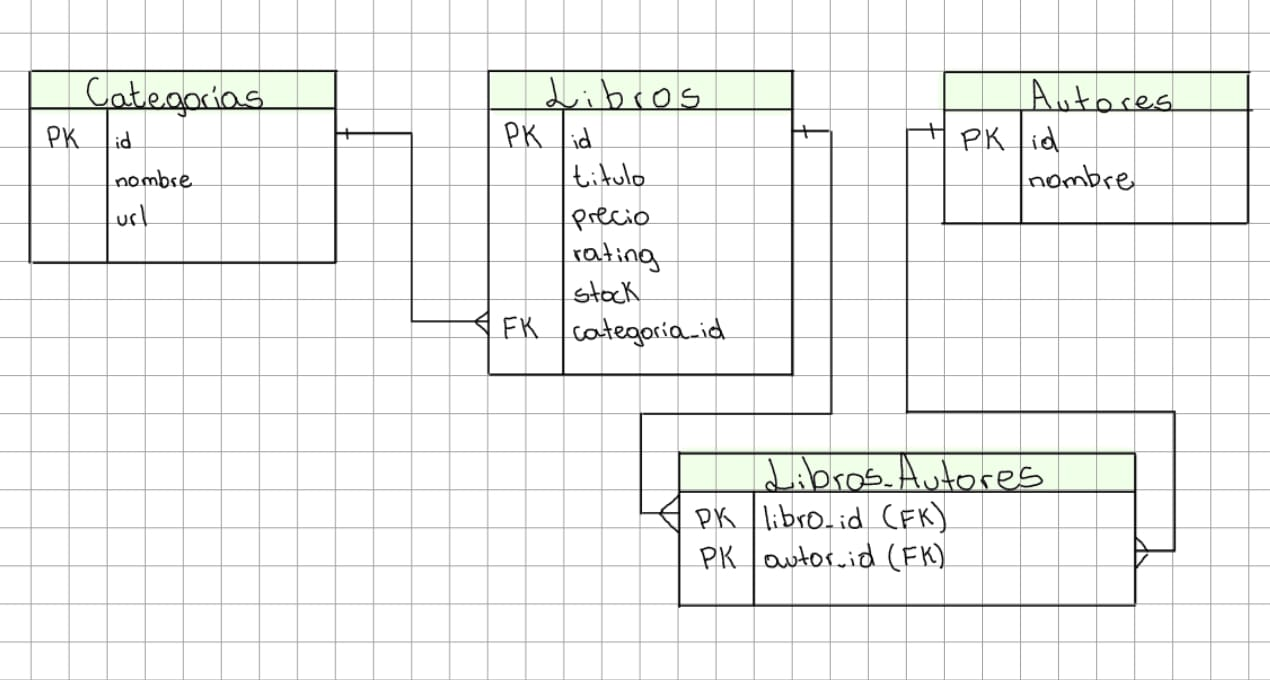

In [ ]:
from IPython.display import Image, display
display(Image(filename="Imagen/DiagramaUML.jpeg"))

### DDL – DATA DEFINITION LANGUAGE

In [ ]:
import sqlite3

conn = sqlite3.connect('libros.db') # SE CREA CONEXION CON LA BASE DE DATOS LLAMADA "libros.db" O LA CREA SI NO EXISTE
cursor = conn.cursor() # CREA UN CURSOR PARA INTECTUAR CON LA BASE DE DATOS

# SE CREA LA TABLA DE CATEGORIAS
cursor.execute('''
CREATE TABLE IF NOT EXISTS categorias (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    nombre TEXT NOT NULL UNIQUE,
    url TEXT NOT NULL
)
''')
print("Tabla categorias creada")

# SE CREA LA TABLA DE LIBROS
cursor.execute('''
CREATE TABLE IF NOT EXISTS libros (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    titulo TEXT NOT NULL,
    precio REAL NOT NULL,
    rating INTEGER CHECK(rating >= 0 AND rating <= 5),
    stock INTEGER DEFAULT 0,
    categoria_id INTEGER NOT NULL,
    FOREIGN KEY (categoria_id) REFERENCES categorias(id)
)
''')
print("Tabla libros creada")

# SE CREA LA TABLA DE AUTORES
cursor.execute('''
CREATE TABLE IF NOT EXISTS autores (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    nombre TEXT NOT NULL UNIQUE
)
''')
print("Tabla autores creada")

# SE CREA LA TABLA DE RELACION LIBROS_AUTORES
# PRIMARY KEY (libro_id, autor_id): CLAVE PRIMARIA COMPUESTA
cursor.execute('''
CREATE TABLE IF NOT EXISTS libros_autores (
    libro_id INTEGER NOT NULL,
    autor_id INTEGER NOT NULL,
    PRIMARY KEY (libro_id, autor_id),
    FOREIGN KEY (libro_id) REFERENCES libros(id),
    FOREIGN KEY (autor_id) REFERENCES autores(id)
)
''')
print("Tabla libros_autores creada")

# SE GUARDAN LOS CAMBIOS EN LA BASE DE DATOS
conn.commit()
# SE CIERRA CONEXION CON LA BASE DE DATOS
conn.close()

Tabla categorias creada
Tabla libros creada
Tabla autores creada
Tabla libros_autores creada


### FUNCIONES DE SCRAPING

In [ ]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time
import re
from urllib.parse import urljoin

BASE_URL = "https://books.toscrape.com/" # URL BASE DE LA PAGINA A EXTRAER LOS LIBROS
GOOGLE_BOOKS_API = "https://www.googleapis.com/books/v1/volumes" # URL DE LA API DE GOOGLE BOOKS API
DB_NAME = 'libros.db' # NOMBRE DE LA BASE DE DATOS


# FUNCION PARA EXTRAER LAS CATEGORIAS
def extraer_categorias():
    response = requests.get(BASE_URL) # SE REALIZA UNA PETICION TIPO GET AL SERVIDOR DE LA PAGINA WEB
    soup = BeautifulSoup(response.content, 'html.parser') # SE PARSEA ESA RESPUESTA Y SE CONVIERTE EN UN OBJETO BEAUTIFULSOUP (ARBOL PARSEADO)
    categorias_html = soup.find('ul', class_='nav nav-list').find('ul').find_all('a') # SE BUSCA DENTRO DEL HTML LOS NOMBRES Y URLS DE LAS CATEGORIAS
    
    categorias = [] # LISTA VACIA EN DONDE SE GUARDARAN DICCIONARIOS CON DOS CLAVES (NOMBRE Y URL DE CADA CATEGORIA)

    # SE ITERA SOBRE CADA CATEGORIA EXTRAIDA
    for cat in categorias_html:
        nombre = cat.text.strip() # SE EXTRAE EL NOMBRE DE LA CATEGORIA
        url = BASE_URL + cat['href'] # SE EXTRAE EL URL COMPLETO DE LA CATEGORIA
        categorias.append({'nombre': nombre, 'url': url}) # SE GUARDAN EN LA LISTA CATEGORIAS
    return categorias


# FUNCION PARA EXTRAER LOS URLS DE CADA LIBRO DENTRO DE LAS CATEGORIAS
def extraer_libros_de_categoria(url_categoria):
    libros_urls = [] # LISTA VACIA EN DONDE SE GUARDARAN LOS URLS DE CADA LIBRO
    pagina_actual = url_categoria # SE DEFINE QUE LA PAGINA ACTUAL SERA EL DE LA CATEGORIA QUE ESTEMOS VISITANDO
    
    # MIENTRAS PAGINA ACTUAL NO SEA NONE
    while pagina_actual:
        response = requests.get(pagina_actual) # SE REALIZA UNA PETICION TIPO GET AL SERVIDOR DE LA PAGINA WEB
        soup = BeautifulSoup(response.content, 'html.parser') # SE PARSEA ESA RESPUESTA Y SE CONVIERTE EN UN OBJETO BEAUTIFULSOUP (ARBOL PARSEADO)
        libros = soup.find_all('article', class_='product_pod') # SE BUSCA TODA LA INFORMACION DEL LIBRO DENTRO DE ESA ETIQUETA Y CLASE

        # SE ITERA SOBRE CADA LIBRO
        for libro in libros:
            link = libro.find('h3').find('a')['href'] # SE BUSCA LA URL DEL LIBRO DENTRO DE ESAS ETIQUETAS
            # SI LA URL COMIENZA CON '../../../'
            if link.startswith('../../../'):
                link = link.replace('../../../', '') # SE REEMPLAZA
            libro_url = urljoin(BASE_URL + 'catalogue/', link) # SE UNE LA URL BASE, CON catalogue/ Y LA URL RELATIVA PARA OBTENER LA URL ABSOLUTA
            libros_urls.append(libro_url) # SE AGREGA LA URL ABSOLUTA A LA LISTA LIBROS_URLS
        
        next_button = soup.find('li', class_='next') # SE BUSCA SI HAY OTRA PAGINA DE LIBROS EN LA CATEGORIA
        
        # SI HAY OTRA PAGINA
        if next_button:
            next_url = next_button.find('a')['href'] # SE BUSCA LA URL DE LA SIGUIENTE PAGINA
            base_categoria = '/'.join(pagina_actual.split('/')[:-1]) # SE OBTIENE LA URL BASE DE CATEGORIAS
            pagina_actual = f"{base_categoria}/{next_url}" # SE OBTIENE LA URL DE LA SIGUIENTE PAGINA
        # SI NO HAY OTRA PAGINA
        else:
            pagina_actual = None 
    return libros_urls


# FUNCION PARA EXTRAER EL STOCK EN NUMEROS ENTEROS
def extraer_stock(disponibilidad_texto):
    match = re.search(r'\((\d+) available\)', disponibilidad_texto) # SE BUSCA DENTRO DE DISPONIBILIDAD_TEXTO UN PATRON Y SE EXTRAE EL NUMERO DENTRO DE ESE PATRON
    # SI HAY MATCH
    if match:
        return int(match.group(1)) # SE LO CONVIERTE DE STRING A NUMERO
    # RETORNA 0 POR DEFECTO (SI NO ENCUENTRA MATCH)
    return 0 


# FUNCION PARA EXTRAER LOS DATOS DE LOS LIBROS
def extraer_libro(url_libro):
    response = requests.get(url_libro) # SE REALIZA UNA PETICION TIPO GET AL SERVIDOR DE LA PAGINA WEB
    soup = BeautifulSoup(response.content, 'html.parser') # SE PARSEA ESA RESPUESTA Y SE CONVIERTE EN UN OBJETO BEAUTIFULSOUP (ARBOL PARSEADO)
    
    titulo = soup.find('h1').text.strip() # SE EXTRAE EL TITULO DEL LIBRO
    
    precio_texto = soup.find('p', class_='price_color').text.strip() # SE EXTRAE EL PRECIO DEL LIBRO EN STRING
    precio = float(precio_texto.replace('£', '')) # SE CONVIERTE A NUMERO DECIMAL Y REEMPLAZAMOS EL SIMBOLO £
    
    rating_class = soup.find('p', class_='star-rating')['class'][1] # SE EXTRAE EL RATING DEL LIBRO
    rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5} # SE CREA UN DICCIONARIO DE LOS RATINGS EXISTENTES
    rating = rating_map.get(rating_class, 0) # DENTRO DEL DICCIONARIO SE BUSCA EN LAS CLAVES EL QUE ES IGUAL AL DEL LIBRO, ASI LO CONVERTIMOS EN NUMERO
    
    disponibilidad = soup.find('p', class_='instock availability').text.strip() # SE EXTRAE LA DISPONIBILIDAD DEL LIBRO
    stock = extraer_stock(disponibilidad) # SE LLAMA A LA FUNCION PARA CONVERTIR LA DISPONIBILIDAD A UN NUMERO ENTERO
    
    # SE RETORNA UN DICCIONARIO CON TODOS LOS DATOS EXTRAIDOS
    return {
        'titulo': titulo,
        'precio': precio,
        'rating': rating,
        'stock': stock}


# FUNCION PARA BUSCAR AUTORES CON LA API DE GOOGLE BOOKS
def buscar_autores_google(titulo):
    try:
        params = {'q': f'intitle:{titulo}', 'maxResults': 1} # SE CREA EL DICCIONARIO CON LOS PARAMETROS A ENVIAR A LA API
        response = requests.get(GOOGLE_BOOKS_API, params=params, timeout=5) # SE REALIZA UNA PETICION TIPO GET A LA API
        data = response.json() # SE CONVIERTE LA RESPUESTA DE FORMATO JSON A UN DICCIONARIO DE PYTHON
        
        # VERIFICA QUE HAYA UNA CLAVE LLAMADA 'ITEMS' Y QUE HAYA POR LO MENOS UNO
        if 'items' in data and len(data['items']) > 0: 
            libro_info = data['items'][0]['volumeInfo'] # SE TOMA EL PRIMER LIBRO DE LA LISTA Y ACCEDEMOS A VOLUMEINFO (QUE ES DONDE ENCONTRAMOS TODOS LOS DATOS DEL LIBRO)
            return libro_info.get('authors', ['Autor Desconocido']) # SE ACCEDE AL AUTOR DEL LIBRO Y SI NO HAY LO TOMA COMO AUTOR DESCONOCIDO
        # SI NO EXISTE LA CLAVE 'ITEMS', LO TOMA COMO AUTOR DESCONOCIDO
        else:
            return ['Autor Desconocido']
    # SI OCURRE ALGUN ERROR, LO TOMA COMO AUTOR DESCONOCIDO 
    except:
        return ['Autor Desconocido']

### FUNCIONES DE DML - DATA MANIPULATION LANGUAGE

In [ ]:
# FUNCION PARA INSERTAR LAS CATEGORIAS A LA BASE DE DATOS
def insertar_categoria(cursor, nombre, url):
    cursor.execute('''
        INSERT OR IGNORE INTO categorias (nombre, url)
        VALUES (?, ?)
    ''', (nombre, url)) 
    cursor.execute('SELECT id FROM categorias WHERE nombre = ?', (nombre,))
    return cursor.fetchone()[0]


# FUNCION PARA INSERTAR LOS AUTORES A LA BASE DE DATOS
def insertar_autor(cursor, nombre):
    cursor.execute('''
        INSERT OR IGNORE INTO autores (nombre)
        VALUES (?)
    ''', (nombre,))
    
    cursor.execute('SELECT id FROM autores WHERE nombre = ?', (nombre,))
    return cursor.fetchone()[0]


# FUNCION PARA INSERTAR LOS LIBROS A LA BASE DE DATOS
def insertar_libro(cursor, libro, categoria_id):
    try:
        cursor.execute('''
            INSERT INTO libros (titulo, precio, rating, stock, categoria_id)
            VALUES (?, ?, ?, ?, ?)
        ''', (libro['titulo'], libro['precio'], libro['rating'], libro['stock'], categoria_id))
        return cursor.lastrowid
    except sqlite3.IntegrityError:
        cursor.execute('SELECT id FROM libros WHERE titulo = ? AND categoria_id = ?', (libro['titulo'], categoria_id))
        result = cursor.fetchone()
        return result[0] if result else None


# FUNCION PARA INSERTAR LAS RELACIONES DE LIBRO_AUTORES A LA BASE DE DATOS
def insertar_libro_autor(cursor, libro_id, autor_id):
    cursor.execute('''
        INSERT OR IGNORE INTO libros_autores (libro_id, autor_id)
        VALUES (?, ?)
    ''', (libro_id, autor_id))

### SCRAPING Y DML

In [ ]:
# FUNCION PARA REALIZAR EL SCRAPING DE LA PAGINA WEB E IR INSERTANDO LOS LIBROS A LA BASE DE DATOS
def scrapear_todo():
    conn = sqlite3.connect(DB_NAME) # SE CREA CONEXION CON LA BASE DE DATOS
    cursor = conn.cursor() # SE CREA EL CURSOR PARA INTERACTUAR CON LA BASE DE DATOS
    
    # SE INICIALIZAR CONTADORES
    total_libros = 0
    total_categorias = 0
    
    try:
        categorias = extraer_categorias() # SE LLAMA A LA FUNCION PARA EXTRAER LAS CATEGORIAS
        
        # SE ITERA SOBRE CATEGORIA
        for i, categoria in enumerate(categorias, 1):
            categoria_id = insertar_categoria(cursor, categoria['nombre'], categoria['url']) # SE LLAMA A LA FUNCION PARA INSERTAR LAS CATEGORIAS
            total_categorias += 1 # SE VA SUMANDO CADA QUE GUARDAMOS UNA CATEGORIA
            
            libros_urls = extraer_libros_de_categoria(categoria['url']) # SE LLAMA A LA FUNCION PARA EXTRAER LOS URLS DE CADA LIBRO DENTRO DE LAS CATEGORIAS
            
            # SE ITERA SOBRE LIBROS_URLS
            for j, url_libro in enumerate(libros_urls, 1):
                try:
                    libro = extraer_libro(url_libro) # SE LLAMA A LA FUNCION PARA EXTRAER CADA LIBRO
                    libro_id = insertar_libro(cursor, libro, categoria_id) # SE LLAMA A LA FUNCION PARA INSERTAR CADA LIBRO

                    autores = buscar_autores_google(libro['titulo']) # SE LLAMA A LA FUNCION PARA BUSCAR LOS AUTORES DE CADA LIBRO
                    # SE ITERA LA LISTA DE AUTORES
                    for autor_nombre in autores:
                        autor_id = insertar_autor(cursor, autor_nombre) # SE LLAMA A LA FUNCION PARA INSERTAR CADA AUTOR
                        insertar_libro_autor(cursor, libro_id, autor_id) # SE LLAMA A LA FUNCION PARA INSERTAR RELACION ENTRE LIBRO_AUTOR
                    total_libros += 1 # SE VA SUMANDO CADA QUE GUARDAMOS UN LIBRO
                    time.sleep(0.2) # PAUSA EL PROGRAMA 0,2 SEGUNDOS ANTES DE CONTINUAR CON EL SIGUIENTE LIBRO

                except Exception as e:
                    continue
            
            # SE GUARDAN LOS DATOS DE LOS LIBROS A LA BASE DE DATOS
            conn.commit()
        
        # MENSAJES DE VERIFICACION
        print(f"\nScraping completado exitosamente.")
        print(f"Total de libros guardados: {total_libros}")
        print(f"Total de categorías procesadas: {total_categorias}")

    # INTERRUPCION CON CTRL + C  
    except KeyboardInterrupt:
        print("Scraping interrumpido por el usuario.")
        conn.commit()
    
    finally:
        conn.close() # CERRAMOS CONEXION CON LA BASE DE DATOS

scrapear_todo()


Scraping completado exitosamente.
Total de libros guardados: 1000
Total de categorías procesadas: 50


### CONSULTA 1

In [18]:
import time
import sqlite3

DB_NAME = 'libros.db'
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

print("Consulta 1: Libros con 5 estrellas ordenados por precio (desc)")

inicio = time.time()

cursor.execute("""
    SELECT titulo, precio, rating
    FROM libros
    WHERE rating = 5
    ORDER BY precio DESC;
""")
resultados = cursor.fetchall()

fin = time.time()

for row in resultados:
    print(row)

print(f"Tiempo de ejecución: {fin - inicio:.4f} segundos")

Consulta 1: Libros con 5 estrellas ordenados por precio (desc)
('The Barefoot Contessa Cookbook', 59.92, 5)
('Life Without a Recipe', 59.04, 5)
('Approval Junkie: Adventures in Caring Too Much', 58.81, 5)
('How to Speak Golf: An Illustrated Guide to Links Lingo', 58.32, 5)
('Digital Fortress', 58.0, 5)
('The Sound Of Love', 57.84, 5)
('Travels with Charley: In Search of America', 57.82, 5)
('El Deafo', 57.62, 5)
('H is for Hawk', 57.42, 5)
('Immunity: How Elie Metchnikoff Changed the Course of Modern Medicine', 57.36, 5)
('The Disappearing Spoon: And Other True Tales of Madness, Love, and the History of the World from the Periodic Table of the Elements', 57.35, 5)
('Kitchens of the Great Midwest', 57.2, 5)
('A Piece of Sky, a Grain of Rice: A Memoir in Four Meditations', 56.76, 5)
('Into the Wild', 56.7, 5)
('Eleanor & Park', 56.51, 5)
('Abstract City', 56.37, 5)
('The False Prince (The Ascendance Trilogy #1)', 56.0, 5)
('Future Shock (Future Shock #1)', 55.65, 5)
("A New Earth: Awaken

### CONSULTA 1 CON INDICE

In [19]:
inicio_indice = time.time()
cursor.execute("CREATE INDEX IF NOT EXISTS idx_libros_rating ON libros(rating)")
conn.commit()
fin_indice = time.time()

print(f"Tiempo en crear el índice: {fin_indice - inicio_indice:.4f} segundos")

print("Consulta 1: Libros con 5 estrellas ordenados por precio (desc)")
inicio_consulta = time.time()

cursor.execute("""
    SELECT titulo, precio, rating
    FROM libros
    WHERE rating = 5
    ORDER BY precio DESC;
""")
resultados = cursor.fetchall()

fin_consulta = time.time()

for row in resultados:
    print(row)

print(f"\nTiempo de ejecución de la consulta: {fin_consulta - inicio_consulta:.4f} segundos")


Tiempo en crear el índice: 0.0013 segundos
Consulta 1: Libros con 5 estrellas ordenados por precio (desc)
('The Barefoot Contessa Cookbook', 59.92, 5)
('Life Without a Recipe', 59.04, 5)
('Approval Junkie: Adventures in Caring Too Much', 58.81, 5)
('How to Speak Golf: An Illustrated Guide to Links Lingo', 58.32, 5)
('Digital Fortress', 58.0, 5)
('The Sound Of Love', 57.84, 5)
('Travels with Charley: In Search of America', 57.82, 5)
('El Deafo', 57.62, 5)
('H is for Hawk', 57.42, 5)
('Immunity: How Elie Metchnikoff Changed the Course of Modern Medicine', 57.36, 5)
('The Disappearing Spoon: And Other True Tales of Madness, Love, and the History of the World from the Periodic Table of the Elements', 57.35, 5)
('Kitchens of the Great Midwest', 57.2, 5)
('A Piece of Sky, a Grain of Rice: A Memoir in Four Meditations', 56.76, 5)
('Into the Wild', 56.7, 5)
('Eleanor & Park', 56.51, 5)
('Abstract City', 56.37, 5)
('The False Prince (The Ascendance Trilogy #1)', 56.0, 5)
('Future Shock (Future 

### CONSULTA 2

In [20]:
print("Consulta 2: Libros con más de 10 unidades en stock")

cursor.execute("""
    SELECT titulo, stock
    FROM libros
    WHERE stock > 10
""")
for row in cursor.fetchall():
    print(row)

Consulta 2: Libros con más de 10 unidades en stock
("It's Only the Himalayas", 19)
('Full Moon over Noah’s Ark: An Odyssey to Mount Ararat and Beyond', 15)
('See America: A Celebration of Our National Parks & Treasured Sites', 14)
('Sharp Objects', 20)
('In a Dark, Dark Wood', 18)
('The Past Never Ends', 16)
('A Murder in Time', 16)
('The Murder of Roger Ackroyd (Hercule Poirot #4)', 15)
('The Last Mile (Amos Decker #2)', 14)
('That Darkness (Gardiner and Renner #1)', 14)
('Tastes Like Fear (DI Marnie Rome #3)', 14)
('A Time of Torment (Charlie Parker #14)', 14)
('A Study in Scarlet (Sherlock Holmes #1)', 14)
('Poisonous (Max Revere Novels #3)', 12)
('Murder at the 42nd Street Library (Raymond Ambler #1)', 12)
('Most Wanted', 12)
('Hide Away (Eve Duncan #20)', 12)
('Boar Island (Anna Pigeon #19)', 12)
('The Widow', 11)
('Playing with Fire', 11)
('Tipping the Velvet', 20)
('Forever and Forever: The Courtship of Henry Longfellow and Fanny Appleton', 16)
('A Flight of Arrows (The Pathfind

### CONSULTA 3

In [21]:
print("Consulta 3: Libros ordenados por rating (mayor a menor)")

cursor.execute("""
    SELECT titulo, precio, rating
    FROM libros
    ORDER BY rating DESC;
""")
for row in cursor.fetchall():
    print(row)

Consulta 3: Libros ordenados por rating (mayor a menor)
('Dark Notes', 19.19, 5)
('The Art and Science of Low Carbohydrate Living', 52.98, 5)
('10-Day Green Smoothie Cleanse: Lose Up to 15 Pounds in 10 Days!', 49.71, 5)
('Suzie Snowflake: One beautiful flake (a self-esteem story)', 54.81, 5)
('(Un)Qualified: How God Uses Broken People to Do Big Things', 54.0, 5)
('All the Light We Cannot See', 29.87, 5)
('How to Stop Worrying and Start Living', 46.49, 5)
("A New Earth: Awakening to Your Life's Purpose", 55.65, 5)
("The Activist's Tao Te Ching: Ancient Advice for a Modern Revolution", 32.24, 5)
('The Four Agreements: A Practical Guide to Personal Freedom', 17.66, 5)
('Someone Like You (The Harrisons #2)', 52.79, 5)
('You (You #1)', 43.61, 5)
('The Elephant Tree', 23.82, 5)
('Born for This: How to Find the Work You Were Meant to Do', 21.59, 5)
('Made to Stick: Why Some Ideas Survive and Others Die', 38.85, 5)
('The Third Wave: An Entrepreneur’s Vision of the Future', 12.61, 5)
('Counted 

### CONSULTA 4

In [22]:
print("Consulta 4: Libros con 'science' en el título")


cursor.execute("""
    SELECT titulo, precio, rating
    FROM libros
    WHERE LOWER(titulo) LIKE '%science%';
""")

for row in cursor.fetchall():
    print(row)

Consulta 4: Libros con 'science' en el título
('Algorithms to Live By: The Computer Science of Human Decisions', 30.81, 1)
('This Is Your Brain on Music: The Science of a Human Obsession', 38.4, 1)
("The Bridge to Consciousness: I'm Writing the Bridge Between Science and Our Old and New Beliefs.", 32.0, 3)
('The Demon-Haunted World: Science as a Candle in the Dark', 52.25, 4)
('Packing for Mars: The Curious Science of Life in the Void', 56.68, 2)
('Mesaerion: The Best Science Fiction Stories 1800-1849', 37.59, 1)
('A Series of Catastrophes and Miracles: A True Story of Love, Science, and Cancer', 56.48, 2)
('Sorting the Beef from the Bull: The Science of Food Fraud Forensics', 44.74, 4)
('Peak: Secrets from the New Science of Expertise', 16.28, 2)
('The Art and Science of Low Carbohydrate Living', 52.98, 5)


### CONSULTA 5

In [23]:
print("Consulta 5: Libro más barato por cada rating")

cursor.execute("""
    SELECT rating, titulo, precio
    FROM libros
    WHERE (rating, precio) IN (
        SELECT rating, MIN(precio)
        FROM libros
        GROUP BY rating
    )
    ORDER BY rating DESC;
""")
for row in cursor.fetchall():
    print(row)

Consulta 5: Libro más barato por cada rating
(5, 'An Abundance of Katherines', 10.0)
(4, 'The Origin of Species', 10.01)
(3, 'Patience', 10.16)
(2, 'The Tipping Point: How Little Things Can Make a Big Difference', 10.02)
(1, 'The Lucifer Effect: Understanding How Good People Turn Evil', 10.4)


### CIERRE DE CONEXION

In [24]:
conn.close()
print("Conexión cerrada")

Conexión cerrada
